In [5]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [4]:
import wordcloud
from wordcloud import WordCloud
import json
from collections import defaultdict
from array import array
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# DATA LOADING PART
import json, gzip
from pathlib import Path

# Function to iterate over JSON objects in a file (handles both JSON Lines and JSON array formats). 
#This code was AI-assisted

def iter_json_objects(path):
    opener = gzip.open if str(path).endswith('.gz') else open
    with opener(path, 'rt', encoding='utf-8') as f:
        first = f.read(1)
        f.seek(0)
        if first == '[':
            try:
                import ijson
                for obj in ijson.items(f, 'item'):
                    yield obj
            except ImportError:
                data = json.load(f)
                for obj in data:
                    yield obj
        else:
            for line in f:
                line = line.strip()
                if line:
                    yield json.loads(line)

# Here we build a path to the dataset, which is two levels up from this notebook
NOTEBOOK_DIR = Path().resolve()
DATA_PATH = NOTEBOOK_DIR.parents[1] / "data" / "fashion_products_dataset.json"

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATA_PATH}. "
        "Please make sure 'fashion_products_dataset.json' is placed in the 'data/' folder at the repo root."
    )

print("Dataset path:", DATA_PATH)

# Load records
records = list(iter_json_objects(DATA_PATH))
print(f"Loaded {len(records)} records successfully")



Dataset path: C:\Users\alber\Documents\GitHub\irwa-search-engine-g_019\data\fashion_products_dataset.json
Loaded 28080 records successfully


In [6]:


#DATA PREPARATION PART

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

#Here we convert strings into numbers safely
def to_number(x):
    if x is None:
        return np.nan
    # Already numeric
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).replace(",", "").strip().lower()
    # Handle '69% off'
    if "% off" in s:
        s = s.split("%")[0]
    # Handle booleans like "true"/"false"
    if s in ["true", "false"]:
        return 1.0 if s == "true" else 0.0
    try:
        return float(s)
    except ValueError:
        return np.nan


# With this we convert the list of product details (a list of dictionaries) into a single text string.
def details_to_text(details):
    """Convert list of detail dicts into a single readable string."""
    if not details:
        return ""
    out = []
    for d in details:
        if isinstance(d, dict):
            for key, val in d.items():
                out.append(f"{key} {val}")
    return " ".join(out)


# Here we process each product record to extract and clean relevant fields.
def process_product(prod):

    # 1) concatenating title, description, product_details
    title = prod.get("title", "")
    desc = prod.get("description", "")
    dets = details_to_text(prod.get("product_details"))
    full_text = f"{title} {desc} {dets}"

    # 2) tokenize, lowercase, remove stopwords, stem
    tokens = word_tokenize(full_text)
    tokens = [t.lower() for t in tokens if t.isalnum()]
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 2]
    clean_text = " ".join(tokens)

    # 3) returning processed row
    return {
        "pid": prod.get("pid", ""),
        "title": title,
        "description": desc,
        "brand": prod.get("brand", ""),
        "category": prod.get("category", ""),
        "sub_category": prod.get("sub_category", ""),
        "product_details": prod.get("product_details", []),
        "seller": prod.get("seller", ""),
        "out_of_stock": to_number(prod.get("out_of_stock")),
        "selling_price": to_number(prod.get("selling_price")),
        "discount": to_number(prod.get("discount")),
        "actual_price": to_number(prod.get("actual_price")),
        "average_rating": to_number(prod.get("average_rating")),
        "url": prod.get("url", ""),
        "tokens": clean_text
    }



In [14]:
# preprocessing function
processed_data = [process_product(rec) for rec in iter_json_objects(DATA_PATH)]

# turn the processed list of dicts into a pandas DataFrame
products_df = pd.DataFrame(processed_data)

# setting product id as the index
products_df.set_index("pid", inplace=True)

# showing the first few rows
products_df.head(4)



,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,url,tokens
pid,,,,,,,,,,,,,,
TKPFCZ9EA7H5FYZH,Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO2'}, {'Closure': 'El...",Shyam Enterprises,0.0,921.0,69.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid women multicolor track pant yorker track...
TKPFCZ9EJZV2UVRZ,Solid Men Blue Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005BLUE'}, {'Closure': 'Draw...",Shyam Enterprises,0.0,499.0,66.0,1499.0,3.9,https://www.flipkart.com/yorker-solid-men-blue...,solid men blue track pant yorker trackpant mad...
TKPFCZ9EHFCY5Z4Y,Solid Men Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO4'}, {'Closure': 'El...",Shyam Enterprises,0.0,931.0,68.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid men multicolor track pant yorker trackpa...
TKPFCZ9ESZZ7YWEF,Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO3'}, {'Closure': 'El...",Shyam Enterprises,0.0,911.0,69.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid women multicolor track pant yorker track...


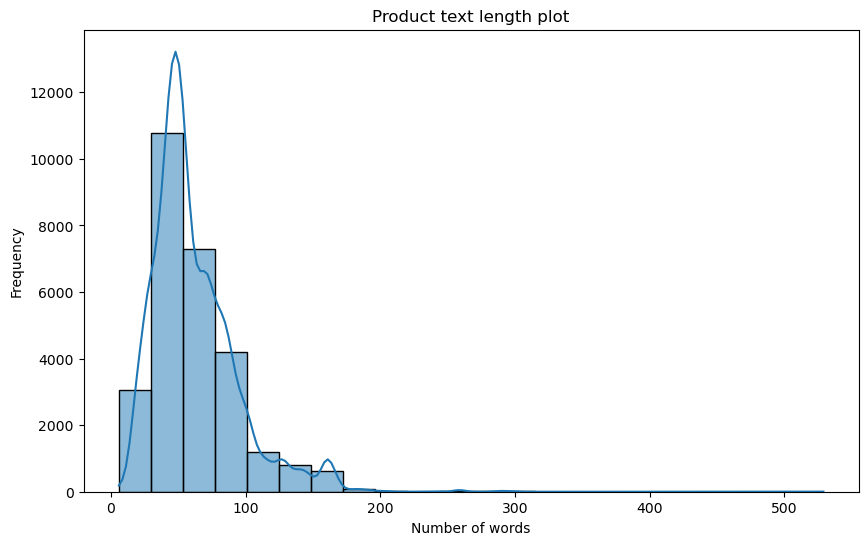

In [9]:
# Product text length plot


vocab_df = products_df.copy()
vocab_df['Wordcount'] = products_df['tokens'].fillna('').apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(vocab_df['Wordcount'], bins=22, kde=True)

plt.title('Product text length plot')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()


In [10]:
# Getting info about our vocabulary (products)

# All product tokens in a single list of words
whole_content = products_df['tokens'].fillna('').str.split().explode().tolist()

# Counting appearances
word_counts = Counter(whole_content)

# Converting to dict
vocab_dict = dict(word_counts)
print('Product vocabulary size is', len(vocab_dict))

# Sorting dictionary items to get the top 5 appearing words
sorted_dict = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
print('\nThe top 5 most appearing words are:')
for item in sorted_dict[:5]:
    print(item)


Product vocabulary size is 15877

The top 5 most appearing words are:
('fabric', 57213)
('neck', 56553)
('sleev', 50876)
('fit', 39523)
('type', 38701)


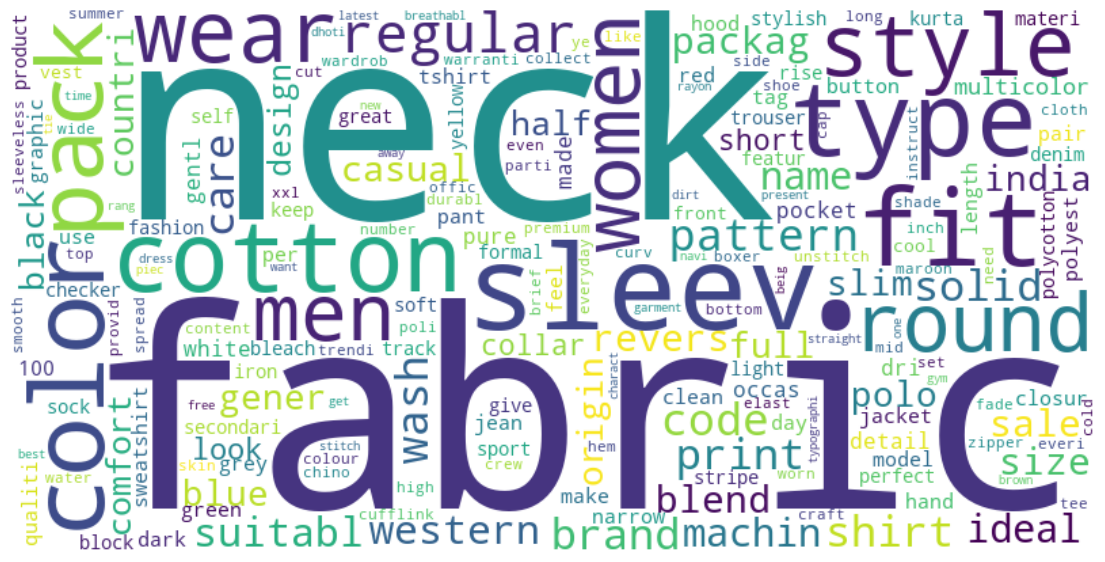

In [11]:
# Generating a word cloud for product tokens
words_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vocab_dict)

plt.figure(figsize=(14,8))
plt.imshow(words_wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [12]:
# Creating a new dataframe sorted by highest rating
rated_df = products_df.copy()
rated_sorted = rated_df.sort_values(by='average_rating', ascending=False)

print('The following are the Top 5 Highest-Rated Products:')
rated_sorted.reset_index().drop(columns=['pid','url'], errors='ignore').head(5)


The following are the Top 5 Highest-Rated Products:


,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,tokens
0,Solid Women Round Neck Blue T-Shirt,,Oka,Clothing and Accessories,Topwear,"[{'Type': 'Round Neck'}, {'Sleeve': 'Half Slee...",OKANE,0.0,385.0,44.0,699.0,5.0,solid women round neck blue type round neck sl...
1,Printed Women Hooded Neck Black T-Shirt,,ATTIITU,Clothing and Accessories,Topwear,"[{'Type': 'Hooded Neck'}, {'Sleeve': 'Full Sle...",ATTIITUDE,0.0,549.0,60.0,1399.0,5.0,print women hood neck black type hood neck sle...
2,Printed Women Hooded Neck Grey T-Shirt,,ATTIITU,Clothing and Accessories,Topwear,"[{'Type': 'Hooded Neck'}, {'Sleeve': 'Full Sle...",Assiduus Distribution,0.0,909.0,35.0,1399.0,5.0,print women hood neck grey type hood neck slee...
3,Graphic Print Men Round Neck Blue T-Shirt,,Free Authori,Clothing and Accessories,Topwear,"[{'Type': 'Round Neck'}, {'Sleeve': 'Half Slee...",BioworldMerchandising,0.0,519.0,35.0,799.0,5.0,graphic print men round neck blue type round n...
4,"Solid Women Round Neck White, Black T-Shirt",Loosen up in this perfectlloose-fit black vest...,ATTIITU,Clothing and Accessories,Topwear,"[{'Type': 'Round Neck'}, {'Sleeve': 'Sleeveles...",Assiduus Distribution,0.0,649.0,35.0,999.0,5.0,solid women round neck white black loosen blac...


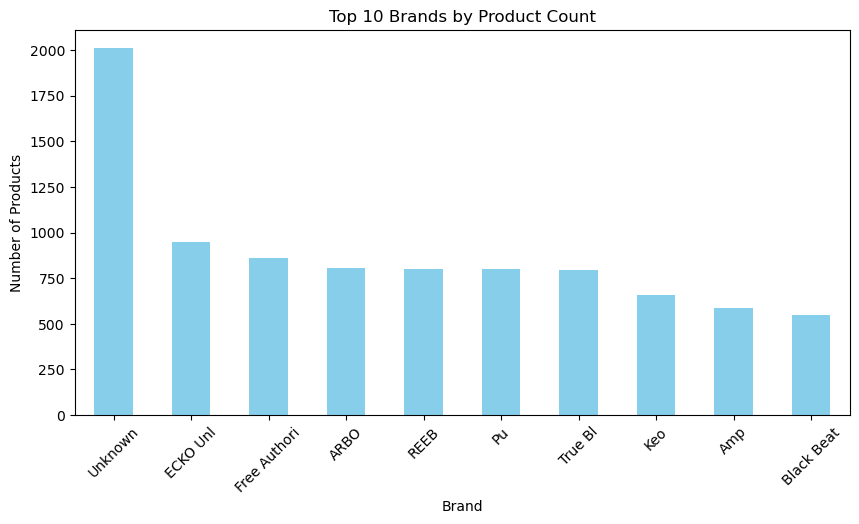

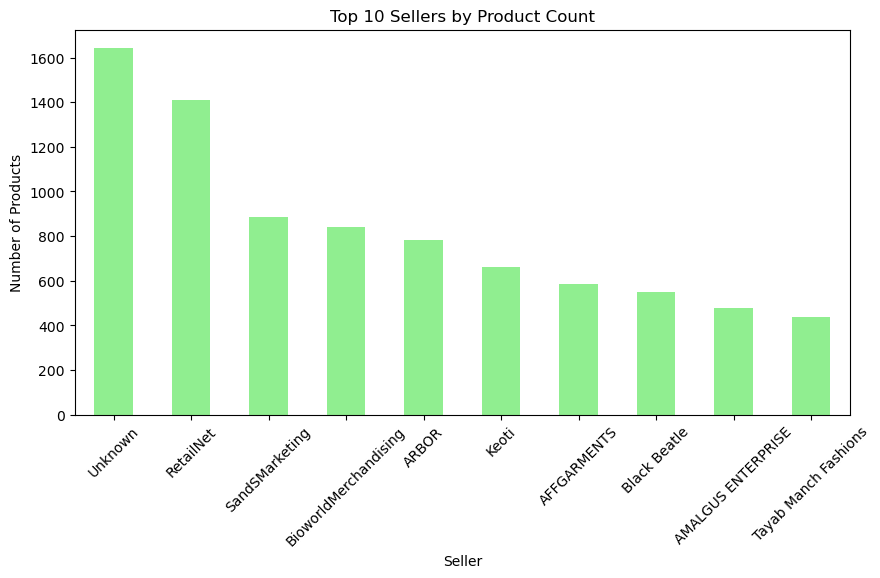

In [13]:
# Fill missing values in 'brand' with 'Unknown' and replace empty strings with 'Unknown'
products_df['brand'] = products_df['brand'].fillna('Unknown')
products_df['brand'] = products_df['brand'].replace('', 'Unknown')
# Get the top 10 most frequent brands
top_brands = products_df['brand'].value_counts().head(10)

# Plot the top 10 brands
plt.figure(figsize=(10,5))
top_brands.plot(kind='bar', color='skyblue')
plt.title('Top 10 Brands by Product Count')
plt.xlabel('Brand')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.show()

# Fill missing values in 'seller' with 'Unknown' and replace empty strings with 'Unknown'
products_df['seller'] = products_df['seller'].fillna('Unknown')
products_df['seller'] = products_df['seller'].replace('', 'Unknown')
# Get the top 10 most frequent sellers
top_sellers = products_df['seller'].value_counts().head(10)

# Plot the top 10 sellers
plt.figure(figsize=(10,5))
top_sellers.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Sellers by Product Count')
plt.xlabel('Seller')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.show()